<a href="https://colab.research.google.com/github/Igor-Belskiy/rbk-case/blob/main/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%91%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np   # для работы с данными
import pandas as pd   # для работы с таблицами
import time    # Импортируем библиотеку time
from datetime import datetime    # Для обработки дат
import re

import matplotlib.pyplot as plt #Отрисовка графиков

from tensorflow.keras.preprocessing.text import Tokenizer   # Методы для работы с текстами и преоборазвания их в последовательности
from tensorflow.keras import utils  # для работы с категориальными данными
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from tensorflow.keras.utils import plot_model     # Для отрисовки моделей

from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from sklearn.model_selection import train_test_split  # Для раздения выборки на тестовую и обучающую

# Загрузка данных

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd   # для загрузки с гугл-драйва в колабораторию

# Копию бучающег и тестовог датасета предварительно загрузил к себе на гугл-диск
# и Колабораторию загружаю их напрямую уже со своего диска (досутуп отркыт для всех по ссылке)

gdd.download_file_from_google_drive(file_id='1OJs8ZLeKe1BflJMGWM5QLbsbMHCiWhJ7', 
                                    dest_path='/content/test_dataset_test.csv', 
                                    showsize=True,
                                    overwrite=True) #Скачиваем тестовый датасет

gdd.download_file_from_google_drive(file_id='1sIbebBPuT3YC6OC-uUP8Q7i3YUJfS2Ad', 
                                    dest_path='/content/train_dataset_train.csv', 
                                    showsize=True,
                                    overwrite=True) #Скачиваем тренировочный датасет

1.2 MiB Done.
2.9 MiB Done.


In [150]:
df_test = pd.read_csv('/content/test_dataset_test.csv', index_col= 0)

df_train = pd.read_csv('/content/train_dataset_train.csv', index_col= 0)

In [4]:
df_train.columns

Index(['title', 'publish_date', 'session', 'authors', 'ctr', 'category',
       'tags', 'views', 'depth', 'full_reads_percent'],
      dtype='object')

# Готовим выходный данные для обучения

## Обрабатываем стобец "views"

In [5]:
df_train['views'].sort_values()

document_id
6236462b9a7947544365254d0664WRQsQRGOIbsqUT0LSw         65
62041eec9a79471dce8208efxEswFOOoQfCF4N1Bk-LgTA         84
6246149a9a79471201b16ca0Lm-NghnfRxGWgbUqr5JFKQ        151
6236a0269a794766048156dff0UsY8pGTL6Q22boUeuU6w        165
626d98eb9a794774ea27e974WDK4DyQ7T5aV1ltVQNkAGg        181
                                                   ...   
62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw    2554204
62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w    2554204
62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg    2554204
62074b119a7947b0e49b36f73kkiEgVVT3qV3E7Hd2cDsg    2554204
62074b119a7947b0e49b36f7iNdNbeY3TLyxxJmCeU8LdA    2554204
Name: views, Length: 7000, dtype: int64

In [6]:
yTrain_views = np.array(df_train['views']).reshape(-1, 1)    # Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.

yTrain_views.shape

(7000, 1)

In [7]:
yViewsScaler = StandardScaler()

yViewsScaler.fit(yTrain_views)       # Тренируем нормировщик на выходных данных views

yTrain_views_Scalered = yViewsScaler.transform(yTrain_views)     # Переводим данные views в нормированную форму с помощью нормировщика

In [8]:
yTrain_views_Scalered.shape

(7000, 1)

## Обрабатываем столбец "depth"

In [9]:
df_train['depth'].sort_values()

document_id
62931bae9a7947448b3cdab4SRPnZWHSRFmlCCZwce5APg    1.016
626a67e19a7947694894d707EcrLAABxS86ihA553FEnAA    1.020
62614a2f9a79479125d98653PUY3qhYWRGSMnqBumpqeiw    1.020
62611dec9a794779e452cfb1Hle9FXT6Sh6us8D8OrseOQ    1.021
62866e759a7947002d54b2be01aClYwET-29ZVkjDNZBHg    1.021
                                                  ...  
62074b119a7947b0e49b36f72XRjXJ3MR0qlf6Jx-rIRbg    1.799
62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg    1.799
62074b119a7947b0e49b36f73kkiEgVVT3qV3E7Hd2cDsg    1.799
62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w    1.799
62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw    1.799
Name: depth, Length: 7000, dtype: float64

In [10]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
yTrain_depth = np.array(df_train['depth']).reshape(-1, 1)    
yTrain_depth.shape

(7000, 1)

In [11]:
yDepthScaler = StandardScaler()

yDepthScaler.fit(yTrain_depth)       # Тренируем нормировщик на выходных данных depth

yTrain_depth_Scalered = yDepthScaler.transform(yTrain_depth)     # Переводим данные views в нормированную форму с помощью нормировщика

In [12]:
yTrain_depth_Scalered.shape

(7000, 1)

## Обрабатываем столбец "full_reads_percent"

In [13]:
df_train['full_reads_percent'].sort_values()

document_id
62074b119a7947b0e49b36f7iNdNbeY3TLyxxJmCeU8LdA      4.978
62074b119a7947b0e49b36f72XRjXJ3MR0qlf6Jx-rIRbg      4.978
62074b119a7947b0e49b36f7yeqcRbtLQuCcsxUjWqbUFg      4.978
62074b119a7947b0e49b36f7LcIC7Zi9RVaJjBx5VlFp3w      4.978
62074b119a7947b0e49b36f7ogeueMGYROCLw1nvmiGQrw      4.978
                                                   ...   
623abb1b9a794723857a6b38asdbqAtwSniZn6glDcdeaw     66.821
623aee679a79473f14281240Dd2iw8x3QwyFsxwT7qsyTQ     67.897
62366acc9a79475cac43e970La4nBiKdRjq-HPcQ4-YKBg     75.729
6271d52c9a7947d7db0ac981ciz7jAbTRRGPTfRmXmajDA    217.550
620493199a794737f29908f0wCy2KZoJSJiKDhPixqcYZg    267.623
Name: full_reads_percent, Length: 7000, dtype: float64

In [14]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
yTrain_reads = np.array(df_train['full_reads_percent']).reshape(-1, 1)    
yTrain_reads.shape

(7000, 1)

In [15]:
yReadsScaler = StandardScaler()

yReadsScaler.fit(yTrain_reads)       # Тренируем нормировщик на выходных данных depth

yTrain_reads_Scalered = yReadsScaler.transform(yTrain_reads)     # Переводим данные views в нормированную форму с помощью нормировщика

In [16]:
yTrain_reads_Scalered.shape

(7000, 1)

## Объединяем целевые столбцы views, depth и full_reads_percent в один массив

In [17]:
yTrainScalered = np.concatenate ( (yTrain_views_Scalered, yTrain_depth_Scalered, yTrain_reads_Scalered), axis=1)

yTrainScalered.shape

(7000, 3)

In [18]:
print(yTrainScalered[0], yTrain_views_Scalered[0], yTrain_depth_Scalered[0], yTrain_reads_Scalered[0])

[-0.10360856  0.44922444  0.11418581] [-0.10360856] [0.44922444] [0.11418581]


# Готовим цифровые входные данные

# Столбец "publish_date"

In [19]:
df_train['publish_date'].sort_values()

document_id
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A    2017-08-07 13:00:27
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A    2018-02-22 14:28:30
605321259a7947663a3b6ab2vgBnAMPBRIOYrUrK0JeEiQ    2021-04-12 11:01:26
609d47119a794795c5f7617dh5z7vG_TQAu5Q7Nwp35LUw    2021-05-14 11:19:24
5afd8e7f9a794772862de199oXkM3UjQQRK7NZTlmVi63A    2021-05-17 14:40:01
                                                         ...         
6293bcc69a79476bca4de7e06uBhesj2TgOK5SlFSHaWiQ    2022-05-29 19:06:09
6293a1b69a7947653ffd66efFYhaM6abQJOYhQqxvb41jg    2022-05-29 19:18:23
6293c7a19a79476e99870dd7VCw7wJgfTKyFEL4JwVcXSQ    2022-05-29 19:29:36
62931bae9a7947448b3cdab4SRPnZWHSRFmlCCZwce5APg    2022-05-29 20:02:22
6293d0179a79477232e448779KjDybk2Qvmz5zQcrJ1S-Q    2022-05-29 20:13:12
Name: publish_date, Length: 7000, dtype: object

In [20]:
# Достаём из даты публикации отдельно месяц, день, час, минуту и день недели.

Train_Publish_Date=[]

for x in range(df_train['publish_date'].shape[0]):
  d = datetime.strptime(df_train['publish_date'][x], '%Y-%m-%d %H:%M:%S')   # Получаем из строки объект типа datetime_object
  Train_Publish_Date.append([d.month, d.day, d.hour, d.minute, d.weekday()])

In [61]:
# Сразу готовим данные тестового дата-сета

Test_Publish_Date=[]

for x in range(df_test['publish_date'].shape[0]):
  d = datetime.strptime(df_test['publish_date'][x], '%Y-%m-%d %H:%M:%S')   # Получаем из строки объект типа datetime_object
  Test_Publish_Date.append([d.month, d.day, d.hour, d.minute, d.weekday()])

Test_Publish_Date = np.array(Test_Publish_Date) 

Test_Publish_Date.shape

(3000, 5)

In [21]:
Train_Publish_Date = np.array(Train_Publish_Date)     # Трансформируем в массив типа numpy

In [22]:
Train_Publish_Date.shape

(7000, 5)

In [65]:
# Нормируем дынные о дате публикации. Для каждой цифры делаем свой MinMaxScaller

Scaler_List = []                   # Список для сохранения объектов нормировщика
Scalered_Train_Publish_Date = []   # Список для сохранения нормированных данных

Scalered_Test_Publish_Date = []   # Список для сохранения нормированных данных тестового датасета

for x in range(Train_Publish_Date.shape[1]):

    Current_DataForScaler =  Train_Publish_Date.T[x].reshape(-1, 1)    # Готовим данные для подачи в нормировщик

    Current_Scaler = MinMaxScaler()                                    # Создаём новый нормировщик
    Current_Scaler.fit(Current_DataForScaler)                          # Тренируем нормировщик
    Scaler_List.append(Current_Scaler)                                 # Сохраняем обученный нормировщик в список

    Current_Scalered_Data = Current_Scaler.transform(Current_DataForScaler)       # Нормируем данные
    Scalered_Train_Publish_Date.append(Current_Scalered_Data)


    Scalered_Test_Publish_Date.append( Current_Scaler.transform( Test_Publish_Date.T[x].reshape(-1, 1) ) )

In [63]:
Scaler_List      # Список с обученными нормировщиками даты

[MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler(),
 MinMaxScaler()]

In [66]:
 # Преобразуем данные в формат numpy и придаём данным нужную форму
Scalered_Train_Publish_Date = np.array(Scalered_Train_Publish_Date).T[0]  

Scalered_Test_Publish_Date = np.array(Scalered_Test_Publish_Date).T[0] 

In [67]:
Scalered_Train_Publish_Date.shape

(7000, 5)

In [68]:
Scalered_Test_Publish_Date.shape

(3000, 5)

In [27]:
Scalered_Train_Publish_Date[0]

array([0.27272727, 0.1       , 0.43478261, 0.49152542, 0.        ])

In [69]:
Scalered_Test_Publish_Date[0]

array([0.09090909, 0.        , 0.73913043, 0.03389831, 0.16666667])

# Готовим столбец CTR

In [70]:
df_train['ctr'].sort_values()

document_id
628cc86b9a79474d02d8b940xnJxG9v0SPygtrcxHx9MUA     0.000
6209266d9a7947267d22e819KMGtFECWQumwEN0ewZx2_A     0.000
61ff6a719a794709da4133c3B0ss8SjSRfa5LxHtciMXqw     0.000
62386e319a7947621669b445fgshRcjKSnanZxhgsO5d4Q     0.000
628f7e7a9a7947c1bb6c80b3aBmKqj9nR6-p-yltvkE5Pg     0.000
                                                   ...  
623c86669a79475a8c852d220PGJl0Z7R-WPMkd66zV7-A    18.771
62889f899a79471f2e5f633aIIClcfBIQBWfSqiNrT8Mpw    19.953
6207ec389a7947de34486e9fJngsbvnSQhywFHQtJ5_dqw    20.990
627a88cf9a794743f350b797rqkVJ5DxRMSUQ-Pj95Q4pQ    22.302
623d82d29a79474e326594ffTcc_fQf3S5KhFDSwStipLA    39.877
Name: ctr, Length: 7000, dtype: float64

In [29]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
xTrain_ctr = np.array(df_train['ctr']).reshape(-1, 1)    
xTrain_ctr.shape

(7000, 1)

In [71]:
# Перед нормированием переводим в формат numpy и корректируем форму данных перед подачей в нормировщик.
xTest_ctr = np.array(df_test['ctr']).reshape(-1, 1)    
xTest_ctr.shape

(3000, 1)

In [30]:
xCtrScaler = MinMaxScaler()  

xCtrScaler.fit(xTrain_ctr)       # Тренируем нормировщик

xTrain_ctr_Scalered = xCtrScaler.transform(xTrain_ctr)     # Переводим данные в нормированную форму с помощью нормировщика

In [31]:
xTrain_ctr_Scalered.shape

(7000, 1)

In [72]:
xTest_ctr_Scalered = xCtrScaler.transform(xTest_ctr)     # Переводим данные в нормированную форму с помощью нормировщика

xTest_ctr_Scalered.shape

(3000, 1)

# Готовим столбец Category

In [73]:
df_train['category'].nunique()

9

In [74]:
maxCategoryCount = 10   # Определяем максимальное количество категорий

category_tokenizer = Tokenizer(num_words=maxCategoryCount, 
                               oov_token='unknown', 
                               char_level=False)

In [75]:
category_tokenizer.fit_on_texts(df_train['category']) # "Скармливаем" категории, т.е. даём в обработку методу, который соберет словарь частотности

items = list(category_tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра (по сути, это словарь частотности слов)

In [76]:
items[:20]      # Смотрим 20 самых популярных слов частотного словаря

[('unknown', 1),
 ('5409f11ce063da9c8b588a12', 2),
 ('5433e5decbb20f277b20eca9', 3),
 ('540d5eafcbb20f2524fc0509', 4),
 ('5409f11ce063da9c8b588a13', 5),
 ('540d5ecacbb20f2524fc050a', 6),
 ('5409f11ce063da9c8b588a18', 7),
 ('5e54e2089a7947f63a801742', 8),
 ('552e430f9a79475dd957f8b3', 9),
 ('5e54e22a9a7947f560081ea2', 10)]

In [77]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю

train_category = []

train_category = category_tokenizer.texts_to_sequences(df_train['category'])

In [78]:
len(train_category)

7000

In [79]:
xTrain_category = category_tokenizer.sequences_to_matrix(train_category)

In [80]:
xTrain_category.shape

(7000, 10)

In [81]:
xTrain_category.sum()

7000.0

In [82]:
# Для тестовых данных
test_category = []

test_category = category_tokenizer.texts_to_sequences(df_test['category'])

xTest_category = category_tokenizer.sequences_to_matrix(test_category)

xTest_category.shape

(3000, 10)

In [83]:
xTest_category.sum()

3000.0

# Готовим столбец с авторами

In [84]:
maxAuthorsCount = 102   # Определяем максимальное количество найденных авторов
                        # Устанавливаем значения на 1 больше, для неопределенных авторов из тестового набора

authors_tokenizer = Tokenizer(num_words=maxAuthorsCount, 
                              oov_token='unknown', 
                              char_level=False)

In [85]:
authors_tokenizer.fit_on_texts(df_train['authors']) # "Скармливаем" авторов, т.е. даём в обработку методу, который соберет словарь частотности

items = list(authors_tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра (по сути, это словарь частотности слов)

In [86]:
len(items)

101

In [87]:
items[:10]      # Смотрим 10 самых популярных слов частотного словаря

[('unknown', 1),
 ("'604f2c199a79478ec0029eae'", 2),
 ("'619226fb9a7947e681606cc3'", 3),
 ("'60bf2f0f9a79475cc856c5a1'", 4),
 ("'5a9fa2e39a79470cd086f61a'", 5),
 ("'5bfd1d039a794755995093f8'", 6),
 ("'5e1ddee09a7947609de2f69b'", 7),
 ("'5a8d11a39a7947c5e1550980'", 8),
 ("'5edf68259a79470758e7ab2d'", 9),
 ("'6130a7379a79472aeb4546e3'", 10)]

In [88]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю

train_authors = []

train_authors = authors_tokenizer.texts_to_sequences(df_train['authors'])

In [89]:
len(train_authors)

7000

In [90]:
xTrain_authors = authors_tokenizer.sequences_to_matrix(train_authors)

In [91]:
xTrain_authors.shape

(7000, 102)

In [92]:
xTrain_authors.sum()

5008.0

In [94]:
# Для тестовых данных

test_authors = []

test_authors = authors_tokenizer.texts_to_sequences(df_test['authors'])

xTest_authors = authors_tokenizer.sequences_to_matrix(test_authors)

xTest_authors.shape

(3000, 102)

In [95]:
xTest_authors.sum()

2179.0

# Объединяем все обработанные данные в один массив

In [53]:
xTrain_main = np.concatenate ( (Scalered_Train_Publish_Date,
                                xTrain_ctr_Scalered, 
                                xTrain_category,
                                xTrain_authors), axis=1)

In [54]:
xTrain_main.shape

(7000, 118)

In [96]:
# Для тестового датасета

xTest_main = np.concatenate ( ( Scalered_Test_Publish_Date,
                                xTest_ctr_Scalered, 
                                xTest_category,
                                xTest_authors), axis=1)

xTest_main.shape

(3000, 118)

# Ещё одну сеть пробуем (5)  ПОКА ЛУЧШАЯ СЕТЬ

In [97]:
# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(xTrain_main, yTrainScalered, test_size=0.2, shuffle=True)

In [98]:
#Создаём нейронку
model_5 = Sequential()
model_5.add(BatchNormalization(input_dim=118))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(1000, activation='tanh'))
model_5.add(Dense(100, activation='relu'))
model_5.add(Dense(3, activation='linear'))

In [99]:
model_5.compile(optimizer=Adam(learning_rate=1e-5), 
                loss='mse', 
                metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 118)              472       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               15232     
                                                                 
 dense_5 (Dense)             (None, 1000)              129000    
                                                                 
 dense_6 (Dense)             (None, 100)               100100    
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 245,107
Trainable params: 244,871
Non-trainable params: 236
______________________________________________

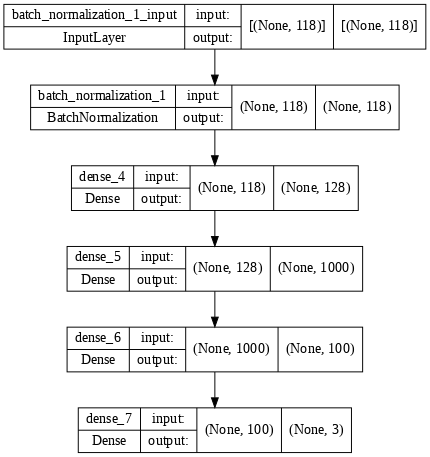

In [100]:
model_5.summary()
plot_model(model_5, dpi=70, show_shapes=True)

In [101]:
history = model_5.fit(x_train, 
                      y_train, 
                      epochs=20,
                      batch_size=10,
                      validation_data=(x_test, y_test))

Epoch 1/20
560/560 [==============================] - 3s 4ms/step - loss: 0.9250 - accuracy: 0.5107 - val_loss: 0.8049 - val_accuracy: 0.5721
Epoch 2/20
560/560 [==============================] - 2s 4ms/step - loss: 0.8172 - accuracy: 0.6300 - val_loss: 0.7648 - val_accuracy: 0.6079
Epoch 3/20
560/560 [==============================] - 2s 4ms/step - loss: 0.7823 - accuracy: 0.6457 - val_loss: 0.7655 - val_accuracy: 0.6207
Epoch 4/20
560/560 [==============================] - 2s 4ms/step - loss: 0.7568 - accuracy: 0.6650 - val_loss: 0.7765 - val_accuracy: 0.6193
Epoch 5/20
560/560 [==============================] - 2s 4ms/step - loss: 0.7450 - accuracy: 0.6684 - val_loss: 0.7805 - val_accuracy: 0.6207
Epoch 6/20
560/560 [==============================] - 2s 4ms/step - loss: 0.7352 - accuracy: 0.6646 - val_loss: 0.7960 - val_accuracy: 0.6243
Epoch 7/20
560/560 [==============================] - 3s 5ms/step - loss: 0.7292 - accuracy: 0.6641 - val_loss: 0.8015 - val_accuracy: 0.6221
Epoch 

# Предиктим на тестовых данных на основе обученной модели

In [102]:
result = model_5.predict(xTest_main)

In [104]:
result.shape

(3000, 3)

# Приводим выход модели из нормированно в обычный вид

In [114]:
result[0]

array([-0.2455253,  1.3662933,  0.8865637], dtype=float32)

In [117]:
result.transpose()[0]          

# Столбецы  0 - View,   1 - depth,  2 - reads

array([-0.2455253 , -0.2275341 , -0.18371132, ...,  0.13050336,
       -0.3234434 , -0.0925562 ], dtype=float32)

In [130]:
views = yViewsScaler.inverse_transform( result.transpose()[0].reshape(-1, 1) )   # Восстановленный столбец views

In [132]:
depth = yDepthScaler.inverse_transform( result.transpose()[1].reshape(-1, 1) )   # Восстановленный столбец depth

In [131]:
reads = yReadsScaler.inverse_transform( result.transpose()[2].reshape(-1, 1) )   # Восстановленный столбец full_reads_percent 

In [133]:
full_result = np.concatenate ( (views, depth, reads), axis=1)

full_result.shape

(3000, 3)

# Присоединяем метки данных к полученному результату и сохраняем в файл csv

In [152]:
df_test.insert(0, 'views', views)

In [153]:
df_test.insert(1, 'depth', depth)

In [154]:
df_test.insert(2, 'full_reads_percent', reads)

In [160]:
df_test = df_test.drop(['title', 'publish_date', 'session', 'authors', 'ctr', 'category', 'tags'], axis = 1 )

In [163]:
df_test.sample(3)


,views,depth,full_reads_percent
document_id,,,
6282c24c9a79473846c46ebam_USFkdETtGZH6Fds7rRiA,28993.982422,1.056818,33.307491
624c0f319a79474d220c0d536fvhR0W0TcWxQeNiza5Z9Q,20314.876953,1.114227,42.390755
61fde5ab9a7947b1649679ebkinL3B-tSgO5JbHXhVuonQ,31557.347656,1.188341,45.183552


In [164]:
# Присоединяем метки данных к полученному результату

df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw to 6236f9129a79477b0ef18ae0ewByZQ1FQBK2dpXyY77rYw
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   views               3000 non-null   float32
 1   depth               3000 non-null   float32
 2   full_reads_percent  3000 non-null   float32
dtypes: float32(3)
memory usage: 58.6+ KB
